# Segmenting and Clustering Neighborhoods in Toronto

Importing the dataframes to be used for this notebook 

In [1]:
import numpy as np 
import pandas as pd
import bs4 as bs
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import lxml.html as lh
import urllib.request
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

### Part 1: Scraping and cleaning the data

The website was scraped for the needed data

In [2]:
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
web = requests.get(link)
web = bs.BeautifulSoup(web.content,'lxml')
table = web.find_all('table')[0]
df = pd.read_html(str(table))
df = pd.read_json(df[0].to_json(orient='records'))
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


Data cleaning and preparation including the removal of boroughs that are not assigned

In [3]:
df_filtered =  df[df['Borough'] != 'Not assigned']

In [4]:
df_filtered

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [5]:
df_filtered = df_filtered.groupby(['Borough', 'Postal Code'], as_index=False).agg(','.join)

In [6]:
df_filtered

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"
...,...,...,...
98,York,M6C,Humewood-Cedarvale
99,York,M6E,Caledonia-Fairbanks
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
101,York,M6N,"Runnymede, The Junction North"


## Part 2: Adding the Geospatial data to the dataframe

In [7]:
geo_data= pd.read_csv('Geospatial_Coordinates.csv')

In [8]:
geo_data

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [9]:
complete_df = pd.merge(df_filtered, geo_data, on = 'Postal Code')
complete_df

,Borough,Postal Code,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160
...,...,...,...,...,...
98,York,M6C,Humewood-Cedarvale,43.693781,-79.428191
99,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013
101,York,M6N,"Runnymede, The Junction North",43.673185,-79.487262


## For merged dataframe

In [10]:
complete_df['Coordinates'] = list(zip(complete_df['Latitude'], complete_df['Longitude']))
complete_df

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,"(43.6895743, -79.38315990000001)"
...,...,...,...,...,...,...
98,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,"(43.6937813, -79.42819140000002)"
99,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,"(43.6890256, -79.453512)"
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,"(43.6911158, -79.47601329999999)"
101,York,M6N,"Runnymede, The Junction North",43.673185,-79.487262,"(43.67318529999999, -79.48726190000001)"


In [11]:
complete_df['Coordinates']  = complete_df['Coordinates'].apply(Point)
complete_df

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.7280205 -79.38879009999999)
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.7127511 -79.3901975)
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.7153834 -79.40567840000001)
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.7043244 -79.38879009999999)
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.6895743 -79.38315990000001)
...,...,...,...,...,...,...
98,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,POINT (43.6937813 -79.42819140000002)
99,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,POINT (43.6890256 -79.453512)
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,POINT (43.6911158 -79.47601329999999)
101,York,M6N,"Runnymede, The Junction North",43.673185,-79.487262,POINT (43.67318529999999 -79.48726190000001)


In [12]:
geo_df = gpd.GeoDataFrame(complete_df, geometry = 'Coordinates')
geo_df

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879)
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020)
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.71538 -79.40568)
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879)
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.68957 -79.38316)
...,...,...,...,...,...,...
98,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,POINT (43.69378 -79.42819)
99,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,POINT (43.68903 -79.45351)
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,POINT (43.69112 -79.47601)
101,York,M6N,"Runnymede, The Junction North",43.673185,-79.487262,POINT (43.67319 -79.48726)


### For the plot

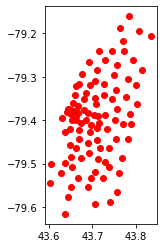

In [13]:
#for the map
city = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = city[city.name == 'Toronto'].plot(color='green', edgecolor='black')

geo_df.plot(ax=ax, color='red')

plt.show()